### Dataset
https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import cv2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

import warnings

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import splitfolders
splitfolders.ratio("../content/gdrive/My Drive/brain_tumor_dataset", output="output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 253 files [00:27,  9.32 files/s]


In [5]:
train_path="/content/output/train"
val_path="/content/output/val"
test_path="/content/output/test"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

list = os.listdir("/content/output/train/yes") + os.listdir("/content/output/train/no") 
Total_Traindata = len(list)

list = os.listdir("/content/output/val/yes") + os.listdir("/content/output/val/no") 
Total_Valdata = len(list)

list = os.listdir("/content/output/test/no") + os.listdir("/content/output/test/no") 
Total_Testdata = len(list)

print (Total_Traindata)
print (Total_Valdata)
print (Total_Testdata)
     

202
24
22


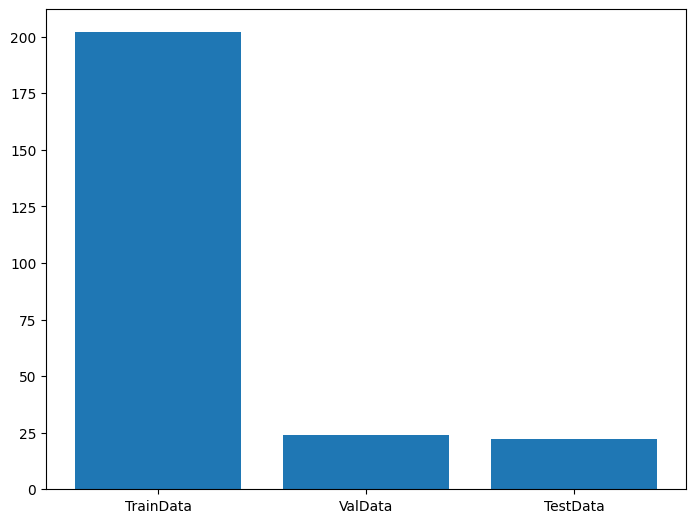

In [6]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['TrainData', 'ValData', 'TestData']
Data = [Total_Traindata,Total_Valdata,Total_Testdata ]
ax.bar(langs,Data)
plt.show()

In [7]:
labels = []
for i in os.listdir(train_path):
    labels+=[i]
labels

['yes', 'no']

In [8]:
import random
import matplotlib.image as mpimg
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(15,15))
  for i in range(3):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,3,i+1)
    ax.title.set_text(label)
    plt.xlabel(f'Name: {file}')
    plt.imshow(img)

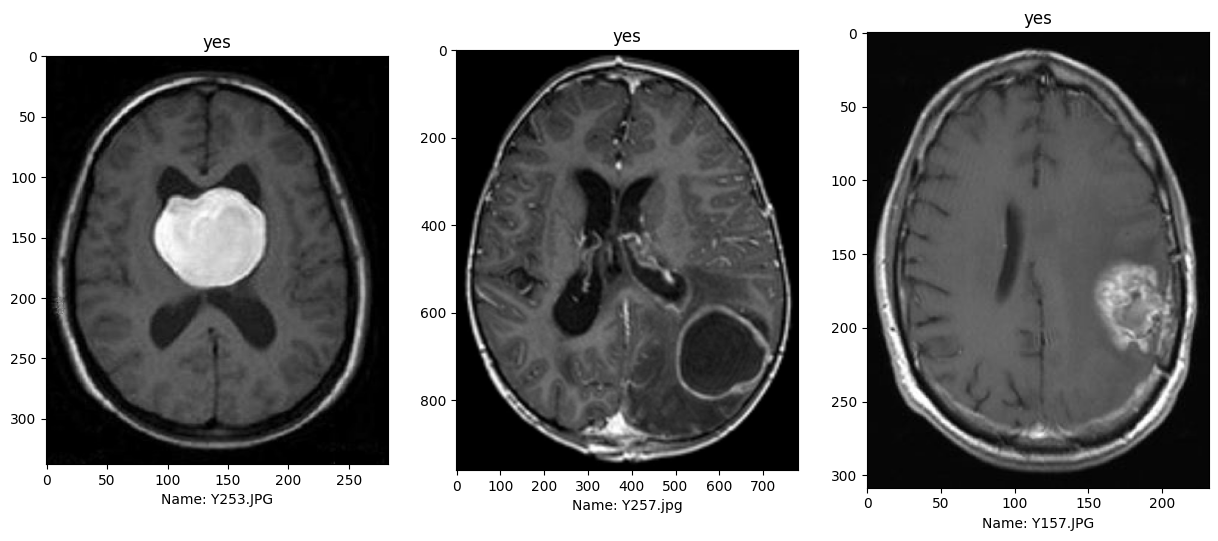

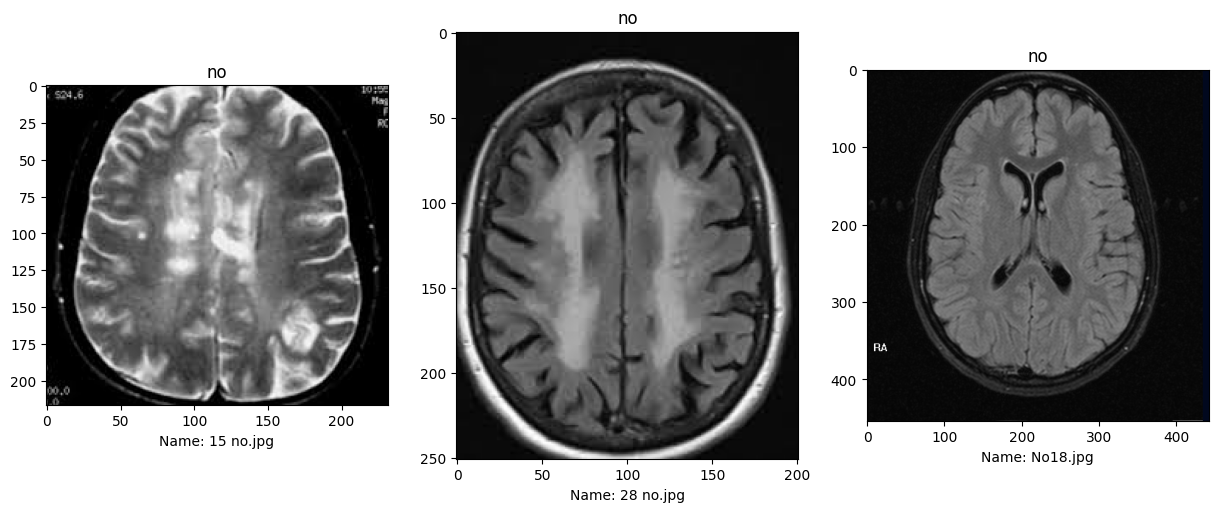

In [9]:
data_dir = "../content/gdrive/My Drive/brain_tumor_dataset"
for label in labels:
    load_random_imgs_from_folder(f"{data_dir}/{label}",label)

In [10]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_path,target_size=(331, 331),batch_size=32,shuffle=True,class_mode='binary')
val_generator = val_datagen.flow_from_directory(val_path,target_size=(331,331),batch_size=32,shuffle=False,class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_path,target_size=(331,331),batch_size=32,shuffle=False,class_mode='binary')

Found 202 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [11]:
from tensorflow.keras.applications import  NASNetLarge

model = NASNetLarge(
      input_shape = (331,331,3),
      include_top = False,
      weights = 'imagenet'
    )
for layers in model.layers:
    layers.trainable = False

343610240/343610240 [==============================] - 3s 0us/step


In [12]:
from keras.layers import  Dropout
x = Flatten()(model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation = "sigmoid")(x)

model = keras.Model(model.input, x)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = "accuracy")
# model.summary()

In [19]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
mc = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', monitor='val_accuracy', mode='max' )
history = model.fit_generator(train_generator,validation_data = val_generator, epochs = 100, verbose=1,callbacks=[mc,es])

Epoch 1/100
7/7 [==============================] - 16s 2s/step - loss: 5.9060 - accuracy: 0.7228 - val_loss: 18.2186 - val_accuracy: 0.6250
Epoch 2/100
7/7 [==============================] - 14s 2s/step - loss: 8.4054 - accuracy: 0.6337 - val_loss: 9.3399 - val_accuracy: 0.4583
Epoch 3/100
7/7 [==============================] - 14s 2s/step - loss: 5.1556 - accuracy: 0.6980 - val_loss: 3.0862 - val_accuracy: 0.7083
Epoch 4/100
7/7 [==============================] - 21s 3s/step - loss: 6.6705 - accuracy: 0.7030 - val_loss: 12.4294 - val_accuracy: 0.6667
Epoch 5/100
7/7 [==============================] - 19s 3s/step - loss: 8.3083 - accuracy: 0.6634 - val_loss: 3.7824 - val_accuracy: 0.7083
Epoch 6/100
7/7 [==============================] - 15s 2s/step - loss: 8.8670 - accuracy: 0.6931 - val_loss: 3.3107 - val_accuracy: 0.7917
Epoch 7/100
7/7 [==============================] - 19s 3s/step - loss: 4.3227 - accuracy: 0.7822 - val_loss: 7.4131 - val_accuracy: 0.7500
Epoch 8/100
7/7 [========

Text(0, 0.5, 'accuracy')

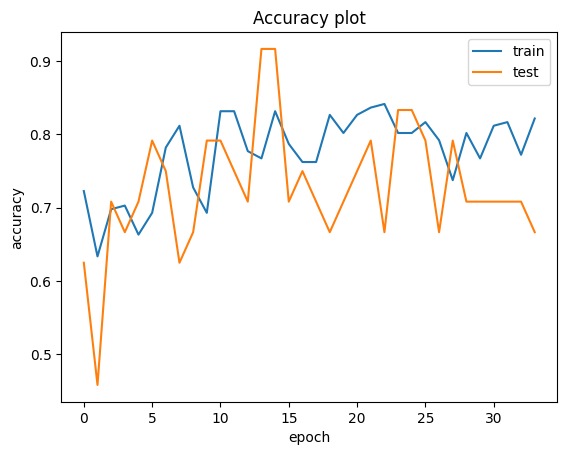

In [20]:
hist = history.history
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
     

Text(0, 0.5, 'loss')

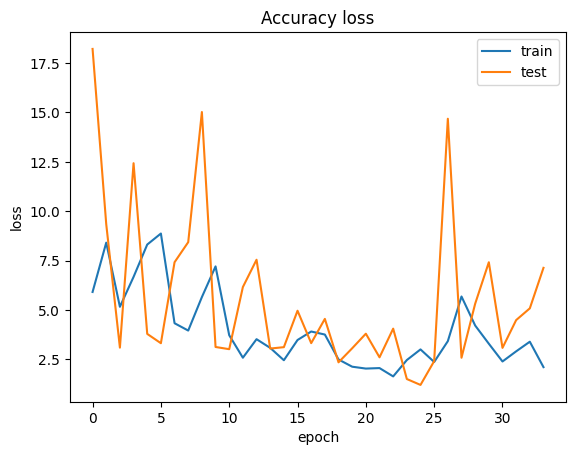

In [21]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")

In [22]:
model.evaluate_generator(test_generator)

[5.076168060302734, 0.7407407164573669]

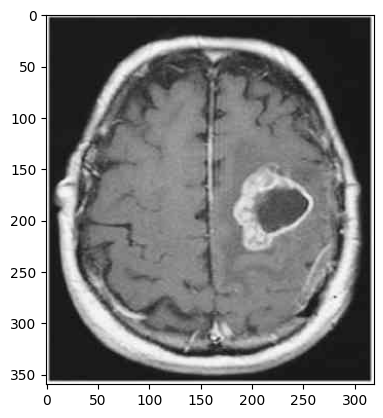

In [23]:

from cv2 import imread
yes_path = test_path+"/yes/"+os.listdir(test_path+"/yes/")[9]

tumour = imread(yes_path)
image_resized= cv2.resize(tumour, (331 ,331))
image=np.expand_dims(image_resized,axis=0)
plt.imshow(tumour)
     


In [24]:
pred=model.predict(image)

output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)


1/1 [==============================] - 0s 51ms/step
The predicted class is yes


In [ ]:
from keras.models import load_model
model1 = load_model('/content/gdrive/MyDrive/best_model.h5')
pred = model1.predict(image)
print(pred)
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)
